**INTRODUCTION :**

        This notebook implements and compares Linear, Ridge, and Bayesian Marketing
        Mix Models to estimate channel contribution, ROI, and effectiveness  of media using
        historical marketing data. The focus is on feature engineering, model
        implementation, and attribution analysis.

**1.IMPORTS**

In [21]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import zipfile
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_squared_error
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import jax.random as random
random.PRNGKey(0)
from sklearn.model_selection import GridSearchCV


**2.READING INPUT FILE**

In [22]:

# Path to ZIP file
zip_path = r"C:\Vaishu__Docs\BITS Documents\Final_Project_Requirements\Sample_Dataset.zip"

# Excel file name inside ZIP
excel_file_name = "ppc_campaign_performance_data.xlsx"

# Open ZIP and read Excel
with zipfile.ZipFile(zip_path, 'r') as z:
    with z.open(excel_file_name) as f:
        df = pd.read_excel(f)

# Verify
df.head()


,Campaign_ID,Budget,Clicks,CTR,CPC,Conversions,CPA,Conversion_Rate,Duration,Platform,Content_Type,Target_Age,Target_Gender,Region,Revenue,Spend,ROAS,Date,Impressions
0,C3578,6390,401,0.0461,15.94,174,36.72,0.4339,20,Instagram,Carousel,35-44,Male,Europe,27840,6453.9,4.31,2025-01-19,8698
1,C6702,9870,1286,0.2860,7.67,821,12.02,0.6384,28,LinkedIn,Text,55+,Male,Africa,128076,10067.4,12.72,2025-01-22,4496
2,C9725,7700,1684,0.2122,4.57,1060,7.26,0.6295,15,Instagram,Video,35-44,Other,North America,193980,7623.0,25.45,2024-07-23,7935
3,C9472,8420,444,0.0961,18.96,308,27.34,0.6937,25,Google,Text,25-34,Male,North America,24024,8504.2,2.82,2024-04-20,4620
4,C7601,8470,1912,0.3652,4.43,1428,5.93,0.7469,9,Google,Text,25-34,Other,Europe,277032,8046.5,34.43,2024-08-07,5235


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Campaign_ID      1000 non-null   object 
 1   Budget           1000 non-null   int64  
 2   Clicks           1000 non-null   int64  
 3   CTR              1000 non-null   float64
 4   CPC              1000 non-null   float64
 5   Conversions      1000 non-null   int64  
 6   CPA              1000 non-null   float64
 7   Conversion_Rate  1000 non-null   float64
 8   Duration         1000 non-null   int64  
 9   Platform         1000 non-null   object 
 10  Content_Type     1000 non-null   object 
 11  Target_Age       1000 non-null   object 
 12  Target_Gender    1000 non-null   object 
 13  Region           1000 non-null   object 
 14  Revenue          1000 non-null   int64  
 15  Spend            1000 non-null   float64
 16  ROAS             1000 non-null   float64
 17  Date           

**3.DATA PREPROCESSING**

1. Convert date to datetime format

In [24]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

2. Creating year,week number columns

In [25]:
iso_calendar = df['Date'].dt.isocalendar()

df['Year'] = iso_calendar.year
df['Week_Num'] = iso_calendar.week

3. Filtering only 2024 data

In [26]:
df = df[df['Date'].dt.year == 2024]

4. Creating week date column having start date of each week

In [27]:
df['Week_Start_Date'] = (
    df['Date']
    - pd.to_timedelta(df['Date'].dt.weekday, unit='D')
)

In [28]:
df

,Campaign_ID,Budget,Clicks,CTR,CPC,Conversions,CPA,Conversion_Rate,Duration,Platform,...,Target_Gender,Region,Revenue,Spend,ROAS,Date,Impressions,Year,Week_Num,Week_Start_Date
2,C9725,7700,1684,0.2122,4.57,1060,7.26,0.6295,15,Instagram,...,Other,North America,193980,7623.0,25.45,2024-07-23,7935,2024,30,2024-07-22
3,C9472,8420,444,0.0961,18.96,308,27.34,0.6937,25,Google,...,Male,North America,24024,8504.2,2.82,2024-04-20,4620,2024,16,2024-04-15
4,C7601,8470,1912,0.3652,4.43,1428,5.93,0.7469,9,Google,...,Other,Europe,277032,8046.5,34.43,2024-08-07,5235,2024,32,2024-08-05
5,C2793,5450,663,0.0932,8.22,605,9.01,0.9125,20,YouTube,...,Other,South America,21780,5177.5,4.21,2024-05-04,7113,2024,18,2024-04-29
6,C8817,4420,1044,0.2902,4.23,452,9.78,0.4330,13,Instagram,...,Male,Europe,51528,4508.4,11.43,2024-08-09,3597,2024,32,2024-08-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992,C5759,4090,620,0.1059,6.60,383,10.68,0.6177,14,Google,...,Female,South America,39832,4253.6,9.36,2024-03-07,5854,2024,10,2024-03-04
994,C9439,5720,1888,0.2612,3.03,143,40.00,0.0757,10,Facebook,...,Female,Africa,27885,5834.4,4.78,2024-04-10,7228,2024,15,2024-04-08
995,C4071,7400,657,0.0986,11.26,136,54.41,0.2070,27,Facebook,...,Other,Europe,24072,7696.0,3.13,2024-08-15,6663,2024,33,2024-08-12
996,C2402,3670,1534,0.1974,2.39,1258,2.92,0.8201,26,LinkedIn,...,Other,Asia,206312,3523.2,58.56,2024-11-08,7771,2024,45,2024-11-04


5. Aggregate raw campaign data to weekly channel-level metrics

In [29]:
df_weekly_channel = (
    df
    .groupby(['Week_Start_Date','Week_Num', 'Platform'])
    .agg({
        'Spend': 'sum',
        'Impressions': 'sum',
        'Clicks': 'sum',
        'Conversions': 'sum'
    })
    .reset_index()
)

In [30]:
df_weekly_channel

,Week_Start_Date,Week_Num,Platform,Spend,Impressions,Clicks,Conversions
0,2024-02-05,6,Facebook,6431.5,9534,82,75
1,2024-02-05,6,Google,9860.0,7334,1494,749
2,2024-02-12,7,Facebook,22438.4,20643,3940,750
3,2024-02-12,7,Google,13302.0,18311,3283,2006
4,2024-02-12,7,Instagram,34332.6,33393,3856,2432
...,...,...,...,...,...,...,...
225,2024-12-23,52,LinkedIn,5460.0,2895,1159,143
226,2024-12-23,52,YouTube,15607.9,8372,3340,1342
227,2024-12-30,1,Google,3893.4,2001,1629,765
228,2024-12-30,1,Instagram,3221.9,2893,579,264


6. Pivot data on channel level for spends

In [31]:
spend_pivot = df_weekly_channel.pivot(
    index='Week_Start_Date',
    columns='Platform',
    values='Spend'
).add_suffix('_Spend')

7. Pivot data on channel level for clicks

In [32]:
clicks_pivot = df_weekly_channel.pivot(
    index='Week_Start_Date',
    columns='Platform',
    values='Clicks'
).add_suffix('_Clicks')

8. Pivot data on channel level for impressions

In [33]:
impr_pivot = df_weekly_channel.pivot(
    index='Week_Start_Date',
    columns='Platform',
    
    values='Impressions'
).add_suffix('_Impressions')

9. Pivot data on channel level for conversions

In [34]:
conv_pivot = df_weekly_channel.pivot(
    index='Week_Start_Date',
    columns='Platform',
    values='Conversions'
).add_suffix('_Conversions')

10. Combine all channel-level media metrics into a single DataFrame

In [35]:


df_channels = (
    spend_pivot
    .join(impr_pivot)
    .join(clicks_pivot)
    .join(conv_pivot)
    .reset_index()
)

In [36]:
df_channels.head()

Platform,Week_Start_Date,Facebook_Spend,Google_Spend,Instagram_Spend,LinkedIn_Spend,YouTube_Spend,Facebook_Impressions,Google_Impressions,Instagram_Impressions,LinkedIn_Impressions,...,Facebook_Clicks,Google_Clicks,Instagram_Clicks,LinkedIn_Clicks,YouTube_Clicks,Facebook_Conversions,Google_Conversions,Instagram_Conversions,LinkedIn_Conversions,YouTube_Conversions
0,2024-02-05,6431.5,9860.0,NaN,NaN,NaN,9534.0,7334.0,NaN,NaN,...,82.0,1494.0,NaN,NaN,NaN,75.0,749.0,NaN,NaN,NaN
1,2024-02-12,22438.4,13302.0,34332.6,35402.5,17099.7,20643.0,18311.0,33393.0,37148.0,...,3940.0,3283.0,3856.0,6714.0,4798.0,750.0,2006.0,2432.0,3707.0,1709.0
2,2024-02-19,29289.0,30516.0,20395.3,14115.7,29237.6,12143.0,29998.0,21751.0,10499.0,...,3784.0,5455.0,3541.0,2936.0,4270.0,1828.0,2410.0,1782.0,1191.0,889.0
3,2024-02-26,25543.1,10262.5,24311.4,24572.0,18884.3,18390.0,17544.0,17189.0,15883.0,...,5726.0,2565.0,3756.0,5123.0,5141.0,4104.0,2027.0,995.0,2951.0,3420.0
4,2024-03-04,20485.1,20647.1,31626.0,30646.1,22772.1,10807.0,29243.0,21152.0,20527.0,...,3633.0,2193.0,2975.0,3860.0,2176.0,1806.0,1518.0,1200.0,2098.0,1028.0


11.Aggregate total business revenue at weekly level

In [37]:
# Weekly total revenue
df_revenue = (
    df.groupby('Week_Start_Date', as_index=False)['Revenue']
      .sum()
)

# Merge revenue with channel metrics
df_final = df_revenue.merge(df_channels, on='Week_Start_Date', how='left')

df_final.head()

,Week_Start_Date,Revenue,Facebook_Spend,Google_Spend,Instagram_Spend,LinkedIn_Spend,YouTube_Spend,Facebook_Impressions,Google_Impressions,Instagram_Impressions,...,Facebook_Clicks,Google_Clicks,Instagram_Clicks,LinkedIn_Clicks,YouTube_Clicks,Facebook_Conversions,Google_Conversions,Instagram_Conversions,LinkedIn_Conversions,YouTube_Conversions
0,2024-02-05,142700,6431.5,9860.0,NaN,NaN,NaN,9534.0,7334.0,NaN,...,82.0,1494.0,NaN,NaN,NaN,75.0,749.0,NaN,NaN,NaN
1,2024-02-12,1102847,22438.4,13302.0,34332.6,35402.5,17099.7,20643.0,18311.0,33393.0,...,3940.0,3283.0,3856.0,6714.0,4798.0,750.0,2006.0,2432.0,3707.0,1709.0
2,2024-02-19,952759,29289.0,30516.0,20395.3,14115.7,29237.6,12143.0,29998.0,21751.0,...,3784.0,5455.0,3541.0,2936.0,4270.0,1828.0,2410.0,1782.0,1191.0,889.0
3,2024-02-26,1604409,25543.1,10262.5,24311.4,24572.0,18884.3,18390.0,17544.0,17189.0,...,5726.0,2565.0,3756.0,5123.0,5141.0,4104.0,2027.0,995.0,2951.0,3420.0
4,2024-03-04,1021111,20485.1,20647.1,31626.0,30646.1,22772.1,10807.0,29243.0,21152.0,...,3633.0,2193.0,2975.0,3860.0,2176.0,1806.0,1518.0,1200.0,2098.0,1028.0


In [38]:
df_final.columns

Index(['Week_Start_Date', 'Revenue', 'Facebook_Spend', 'Google_Spend',
       'Instagram_Spend', 'LinkedIn_Spend', 'YouTube_Spend',
       'Facebook_Impressions', 'Google_Impressions', 'Instagram_Impressions',
       'LinkedIn_Impressions', 'YouTube_Impressions', 'Facebook_Clicks',
       'Google_Clicks', 'Instagram_Clicks', 'LinkedIn_Clicks',
       'YouTube_Clicks', 'Facebook_Conversions', 'Google_Conversions',
       'Instagram_Conversions', 'LinkedIn_Conversions', 'YouTube_Conversions'],
      dtype='object')

**4. EXPLORATORY DATA ANALYSIS**

1. Basic checks

In [39]:
# Replace missing channel values with zero
metric_cols = [c for c in df_final.columns if "Spend" in c or "Impressions" in c or "Clicks"  in c or "Conversions" in c]
df_final[metric_cols] = df_final[metric_cols].fillna(0)



In [40]:
df_final.isna().sum()

Week_Start_Date          0
Revenue                  0
Facebook_Spend           0
Google_Spend             0
Instagram_Spend          0
LinkedIn_Spend           0
YouTube_Spend            0
Facebook_Impressions     0
Google_Impressions       0
Instagram_Impressions    0
LinkedIn_Impressions     0
YouTube_Impressions      0
Facebook_Clicks          0
Google_Clicks            0
Instagram_Clicks         0
LinkedIn_Clicks          0
YouTube_Clicks           0
Facebook_Conversions     0
Google_Conversions       0
Instagram_Conversions    0
LinkedIn_Conversions     0
YouTube_Conversions      0
dtype: int64

In [41]:
df_final.shape

(48, 22)

2.Sorting Date and identifying gaps 

In [42]:
df_final['Week_Start_Date'] = pd.to_datetime(df_final['Week_Start_Date'])
df_final = df_final.sort_values('Week_Start_Date')

In [43]:
df_final['gap'] = df_final['Week_Start_Date'].diff()
df_final['gap'].value_counts()

gap
7 days    47
Name: count, dtype: int64

3. Revenue trend over time

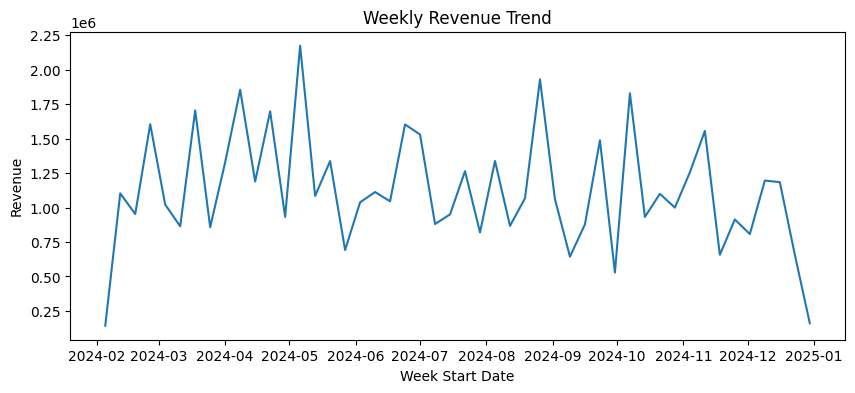

In [44]:
# Plot weekly total revenue to inspect overall trend and seasonality
plt.figure(figsize=(10,4))

# Revenue aggregated at weekly level
plt.plot(df_final['Week_Start_Date'], df_final['Revenue'])

plt.title("Weekly Revenue Trend")
plt.xlabel("Week Start Date")
plt.ylabel("Revenue")

plt.show()

4. 4-Week Moving Average — Revenue Trend

<Axes: xlabel='Week_Start_Date'>

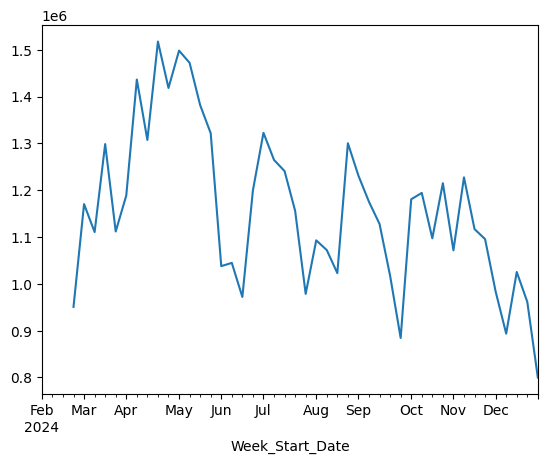

In [45]:
df_final.set_index('Week_Start_Date')['Revenue'].rolling(4).mean().plot()

In [46]:
df_mmm = df_final.copy()
df_mmm.fillna(0, inplace=True)

C:\Users\Vaishali\AppData\Local\Temp\ipykernel_12004\433012101.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with timedelta64[ns], please explicitly cast to a compatible dtype first.
  df_mmm.fillna(0, inplace=True)


3. Channel spend trends

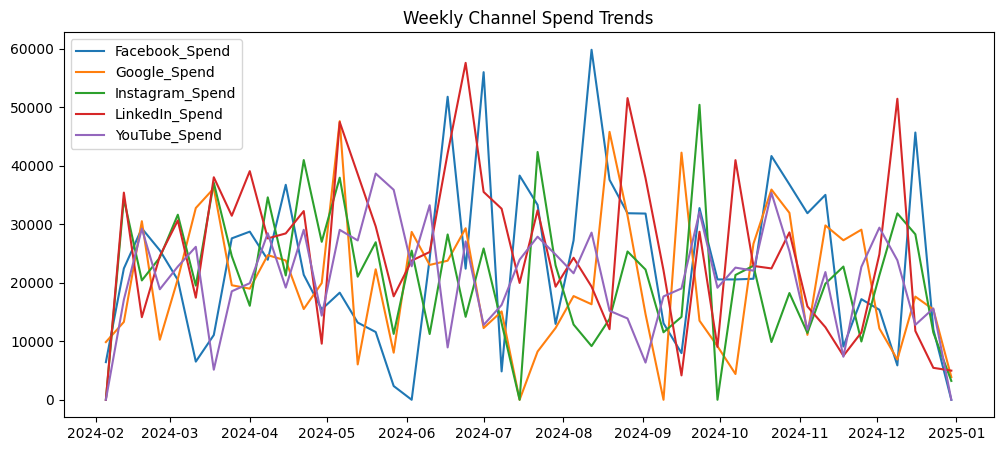

In [47]:
spend_cols = [
    'Facebook_Spend', 'Google_Spend', 'Instagram_Spend',
    'LinkedIn_Spend', 'YouTube_Spend'
]

plt.figure(figsize=(12,5))
for col in spend_cols:
    plt.plot(df_mmm['Week_Start_Date'], df_mmm[col], label=col)

plt.legend()
plt.title("Weekly Channel Spend Trends")
plt.show()


4. Spend Distribution Skewness Check

In [48]:
df_mmm[spend_cols].describe()

,Facebook_Spend,Google_Spend,Instagram_Spend,LinkedIn_Spend,YouTube_Spend
count,48.000000,48.000000,48.000000,48.000000,48.000000
mean,23318.520833,19911.187500,20922.610417,25423.864583,20870.862500
std,14302.937136,11502.716425,11232.156606,13444.915633,8909.806235
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12731.150000,11917.875000,12528.475000,15496.375000,15508.000000
50%,21880.600000,18356.250000,21257.800000,24712.650000,21945.100000
75%,32100.725000,28783.050000,26939.750000,33337.150000,27388.550000
max,59813.100000,47613.100000,50406.300000,57573.100000,38663.300000


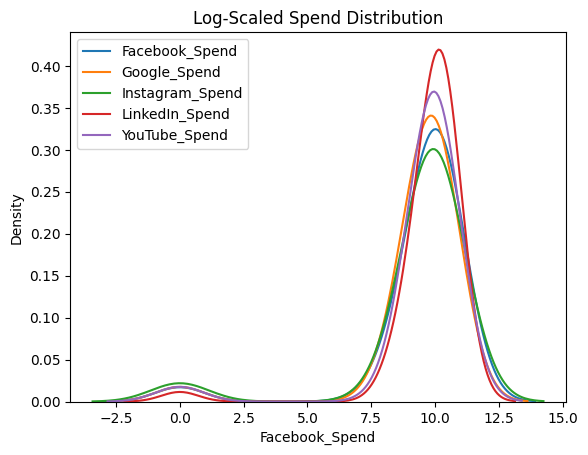

In [49]:
for col in spend_cols:
    sns.kdeplot(np.log1p(df_mmm[col]), label=col)

plt.title("Log-Scaled Spend Distribution")
plt.legend()
plt.show()

Log scaling makes spends more normally distributed and prevents high-spend weeks from dominating the model.

4. Correlation heatmap

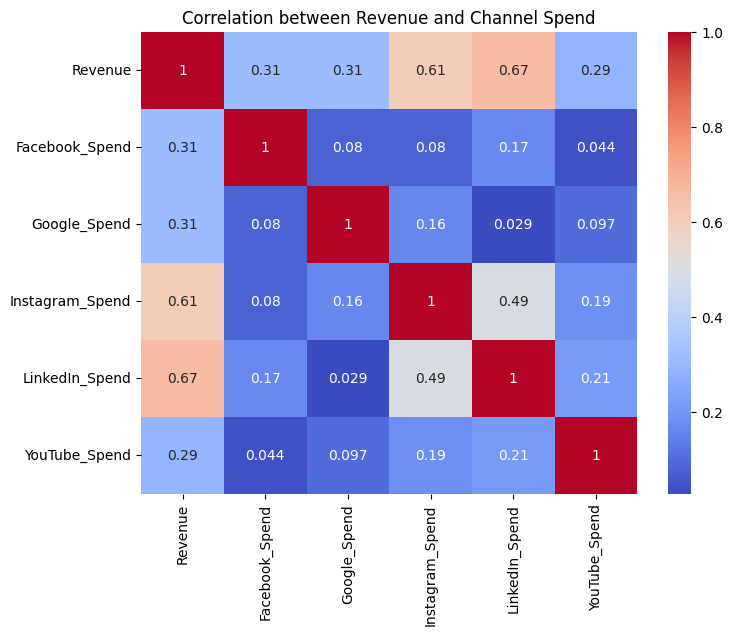

In [50]:


corr = df_mmm[['Revenue'] + spend_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation between Revenue and Channel Spend")
plt.show()


Revenue appears more responsive to LinkedIn and Instagram compared to other channels,Correlation analysis shows that LinkedIn and Instagram have the strongest positive association with revenue, while other channels show weaker relationships. Cross-channel correlations are low, indicating limited multicollinearity risk.

**4.  FEATURE ENGINEERING**

1.Create time trend (baseline demand)

In [51]:
df_mmm = df_mmm.sort_values("Week_Start_Date")
df_mmm['trend'] = range(1, len(df_mmm) + 1)

Trend variable captures gradual underlying demand shifts over time (independent of marketing).

2.Adstock transformation (carryover effect)

In [52]:
def geometric_adstock(series, decay=0.5):
    """
    Applies geometric adstock to a pandas Series or numpy array.

    decay: 0–1
        0   = no carryover
        0.5 = medium carryover
        0.9 = very strong carryover
    """
    
    # keep decay safe
    decay = max(0, min(decay, 0.99))

    adstocked = []
    prev = 0

    for x in series:
        val = x + decay * prev
        adstocked.append(val)
        prev = val

    return np.array(adstocked)



# ---  Apply adstock to each spend column ---
for col in spend_cols:
    df_mmm[col + "_adstock"] = geometric_adstock(df_mmm[col].values, decay=0.5)

Adstock transformation models the lingering effect of media, preventing the model from assuming all impact happens instantly

3.Saturation (diminishing returns)

In [53]:
for col in spend_cols:
    df_mmm[col + '_sat'] = np.log1p(df_mmm[col + '_adstock'])


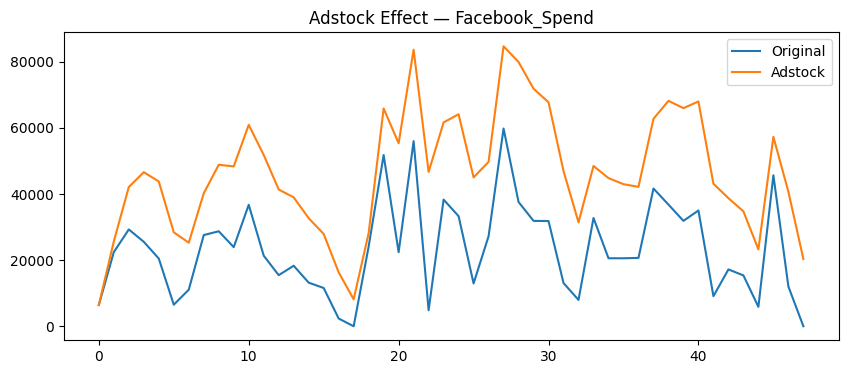

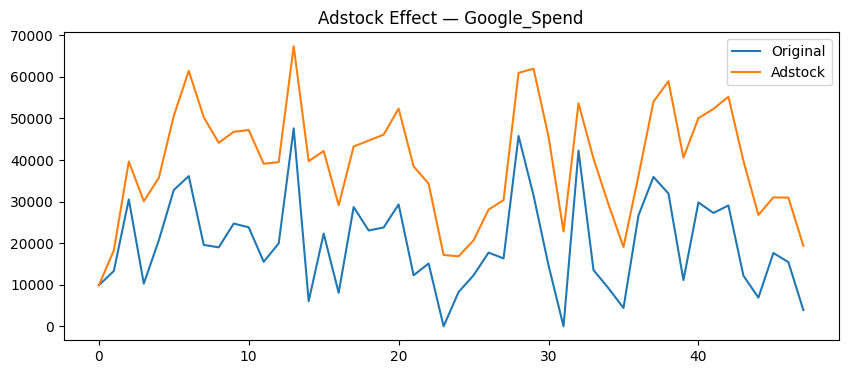

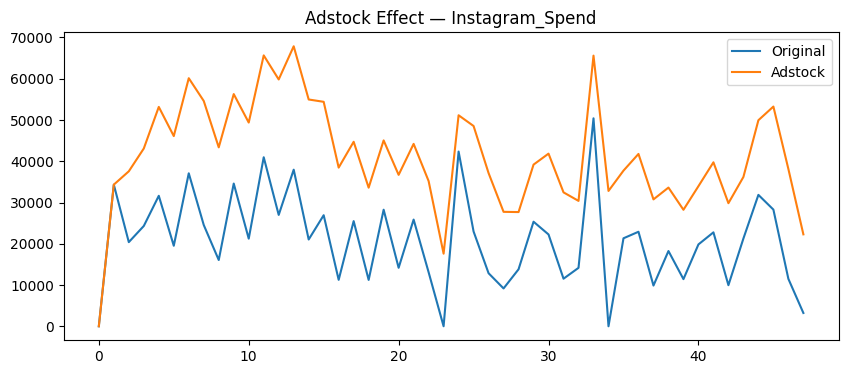

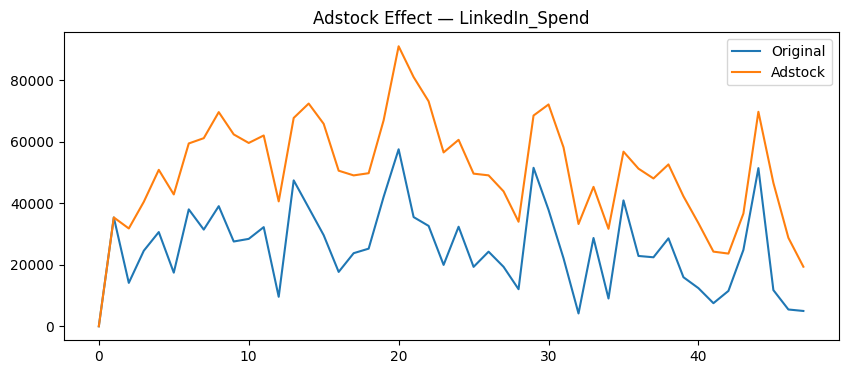

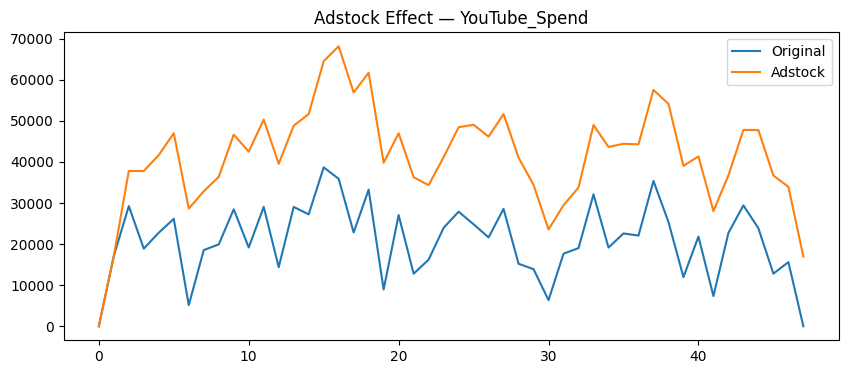

In [54]:
for col in spend_cols:
    plt.figure(figsize=(10,4))
    plt.plot(df_mmm[col], label="Original")
    plt.plot(df_mmm[col + "_adstock"], label="Adstock")
    plt.legend()
    plt.title(f"Adstock Effect — {col}")
    plt.show()

Log transform applies saturation so incremental impact decreases at higher spending levels.

4. Feature selection

In [55]:
media_cols = [col + '_sat' for col in spend_cols]
df_mmm['trend_scaled'] = (df_mmm['trend'] - df_mmm['trend'].mean()) / df_mmm['trend'].std()
X = df_mmm[media_cols + ['trend_scaled']]
y = df_mmm['Revenue']


Model inputs include adstock + saturation media features and a scaled time trend to control baseline demand

Spend vs Revenue correlation

In [56]:
df_mmm[spend_cols + ['Revenue']].corr()

,Facebook_Spend,Google_Spend,Instagram_Spend,LinkedIn_Spend,YouTube_Spend,Revenue
Facebook_Spend,1.000000,0.080008,0.079738,0.168546,0.043690,0.310020
Google_Spend,0.080008,1.000000,0.161859,0.028590,0.097136,0.309867
Instagram_Spend,0.079738,0.161859,1.000000,0.492009,0.186441,0.606503
LinkedIn_Spend,0.168546,0.028590,0.492009,1.000000,0.213063,0.665981
YouTube_Spend,0.043690,0.097136,0.186441,0.213063,1.000000,0.289534
Revenue,0.310020,0.309867,0.606503,0.665981,0.289534,1.000000


**5. LINEAR REGRESSION MODEL**

1. Train & Prediction

In [57]:
lin_model = LinearRegression()
lin_model.fit(X, y)

y_pred = lin_model.predict(X)


2.Model performance

In [58]:
r2 = r2_score(y, y_pred)
rmse = mean_squared_error(y, y_pred) ** 0.5

In [59]:
r2,rmse

(0.37891513255418496, 329989.5055523117)

Baseline Linear Regression achieves R² of ~0.38, indicating moderate explanatory power. However, the model struggles to capture seasonal fluctuations and structural demand shifts, suggesting the need for regularization and additional features such as seasonality

3.Channel Contribution and ROI Calculation

In [60]:
coefs = pd.Series(lin_model.coef_, index=X.columns)

linear_contrib = (X[media_cols] * coefs[media_cols]).sum()

linear_contrib.index = [c.replace('_sat', '') for c in linear_contrib.index]
linear_contrib


Facebook_Spend     8.495643e+07
Google_Spend       1.303888e+08
Instagram_Spend    8.203966e+06
LinkedIn_Spend     1.299344e+08
YouTube_Spend     -1.081100e+08
dtype: float64

In [61]:
total_spend = df_mmm[spend_cols].sum()

linear_roi_df = pd.DataFrame({
    "Revenue_Contribution": linear_contrib,
    "Spend": total_spend,
    "ROI": linear_contrib / total_spend



})

linear_roi_df

,Revenue_Contribution,Spend,ROI
Facebook_Spend,8.495643e+07,1119289.0,75.902140
Google_Spend,1.303888e+08,955737.0,136.427477
Instagram_Spend,8.203966e+06,1004285.3,8.168960
LinkedIn_Spend,1.299344e+08,1220345.5,106.473414
YouTube_Spend,-1.081100e+08,1001801.4,-107.915586


4. CONCLUSION 

The Linear Regression MMM produces extremely high ROI estimates and negative contributions for certain channels. This behavior is expected due to the model’s deterministic nature and its inability to handle multicollinearity and uncertainty. The results highlight the tendency of linear models to over-attribute revenue and produce unstable coefficient estimates, thereby motivating the use of regularized and Bayesian approaches.

**5. RIDGE REGRESSION**


1.Scaling

In [62]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

2. Model Training

In [63]:
ridge_model = Ridge(alpha=10) 
ridge_model.fit(X_scaled, y)
Ridge(alpha=10)

,alpha,10
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


3. Model Perfomance

In [64]:
y_pred_full = ridge_model.predict(X_scaled)
ridge_r2 = r2_score(y, y_pred_full)
rmse_ridge = mean_squared_error(y, y_pred_full) ** 0.5
ridge_r2,rmse_ridge

(0.3453577714744729, 338786.942036448)

4.Ridge Coefficients

In [65]:
ridge_coefs = pd.Series(
    ridge_model.coef_,
    index=X.columns)

ridge_coefs

Facebook_Spend_sat     85976.447051
Google_Spend_sat       81473.256373
Instagram_Spend_sat    37133.358323
LinkedIn_Spend_sat     72367.205984
YouTube_Spend_sat      -8619.815978
trend_scaled          -99813.281656
dtype: float64

5.Channel Contribution

In [66]:
media_idx = list(range(len(media_cols)))
ridge_channel_contrib = {}
for i, col in enumerate(media_cols):
    X_cf = X.copy()
    # Turn off this channel (true zero spend) 
    X_cf[col] = 0
    # Re-scale for model
    X_cf_scaled = scaler.transform(X_cf)
    # Predict
    y_cf = ridge_model.predict(X_cf_scaled)
    # Contribution
    ridge_channel_contrib[col.replace('_sat', '')] = ( y_pred_full.sum() - y_cf.sum() )
ridge_channel_contrib = pd.Series(ridge_channel_contrib)
ridge_channel_contrib

Facebook_Spend     8.466356e+07
Google_Spend       1.006600e+08
Instagram_Spend    1.201405e+07
LinkedIn_Spend     2.326864e+07
YouTube_Spend     -2.788700e+06
dtype: float64

6. ROI Calculation

In [67]:
total_spend = df_mmm[spend_cols].sum()

ridge_roi_df = pd.DataFrame({
    "Revenue_Contribution": ridge_channel_contrib,
    "Spend": total_spend,
    "ROI": ridge_channel_contrib / total_spend
})

ridge_roi_df


,Revenue_Contribution,Spend,ROI
Facebook_Spend,8.466356e+07,1119289.0,75.640478
Google_Spend,1.006600e+08,955737.0,105.321827
Instagram_Spend,1.201405e+07,1004285.3,11.962789
LinkedIn_Spend,2.326864e+07,1220345.5,19.067255
YouTube_Spend,-2.788700e+06,1001801.4,-2.783686


7. Conclusion

Ridge Regression significantly reduces the extreme ROI values observed in the Linear MMM by penalizing large coefficients and mitigating multicollinearity. While dominant channels such as Google and Facebook continue to show strong positive returns, weaker channels exhibit reduced or near-zero contributions, indicating more realistic and stable attribution. Compared to Linear Regression, Ridge produces more reliable estimates suitable for comparative analysis, though it remains deterministic and does not quantify uncertainty.

**6. BAYESIAN REGRESSION**

1. Add seasonality

In [68]:
# Ensure date is datetime
df_mmm['Week_Start_Date'] = pd.to_datetime(df_mmm['Week_Start_Date'])

# Extract week of year
df_mmm['weekofyear'] = df_mmm['Week_Start_Date'].dt.isocalendar().week.astype(int)
season_dummies = pd.get_dummies(
    df_mmm['weekofyear'],
    prefix='wk',
    drop_first=True)  # avoid dummy variable trap

2. Add Baseline Control

In [69]:
df_mmm['Revenue_lag1'] = df_mmm['Revenue'].shift(1).fillna(0)

3. Add log revenue

In [70]:
y = np.log1p(df_mmm['Revenue'].values)

4. Build Feature Matrix X

In [71]:
season_cols = [col for col in df_mmm.columns if col.startswith('wk_')]

X = pd.concat(
    [
        df_mmm[media_cols + ['trend', 'Revenue_lag1']],
        df_mmm[season_cols]
    ],
    axis=1
)

5. STANDARDIZATION

In [72]:
X_scaler = StandardScaler()
y_scaler = StandardScaler()

X_scaled = X_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y.reshape(-1, 1)).ravel()

5. Bayesian MMM

In [73]:
def bayesian_mmm(X, y=None):
    n_features = X.shape[1]

    # Strong shrinkage prior 
    betas = numpyro.sample(
        "betas",
        dist.Normal(0, 0.3).expand([n_features])
    )

    intercept = numpyro.sample("intercept", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))

    mu = intercept + jnp.dot(X, betas)

    numpyro.sample("obs", dist.Normal(mu, sigma), obs=y)

3. Run MCMC

In [74]:
rng_key = random.PRNGKey(0)

nuts_kernel = NUTS(bayesian_mmm)

mcmc = MCMC(
    nuts_kernel,
    num_warmup=1000,
    num_samples=2000,
    num_chains=2
)

mcmc.run(
    rng_key,
    X=jnp.array(X_scaled),
    y=jnp.array(y_scaled)
)


C:\Users\Vaishali\AppData\Local\Temp\ipykernel_12004\2528257359.py:5: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|██████████| 3000/3000 [00:01<00:00, 2453.91it/s, 15 steps of size 2.30e-01. acc. prob=0.93]


4.MCMC Summary

In [75]:
mcmc.print_summary()


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
   betas[0]      0.31      0.11      0.31      0.12      0.48   3849.74      1.00
   betas[1]      0.23      0.11      0.23      0.07      0.41   4265.19      1.00
   betas[2]      0.14      0.23      0.14     -0.23      0.51   2965.40      1.00
   betas[3]      0.29      0.23      0.30     -0.09      0.66   2891.46      1.00
   betas[4]      0.07      0.22      0.07     -0.28      0.45   2896.93      1.00
   betas[5]     -0.29      0.10     -0.29     -0.44     -0.12   4081.72      1.00
   betas[6]     -0.23      0.10     -0.23     -0.40     -0.07   3947.66      1.00
  intercept      0.00      0.09      0.00     -0.15      0.15   3811.50      1.00
      sigma      0.65      0.08      0.65      0.53      0.76   3331.39      1.00

Number of divergences: 0


5. Posterior Means

In [76]:
posterior = mcmc.get_samples()

beta_means = posterior['betas'].mean(axis=0)
intercept_mean = posterior['intercept'].mean()

5. Full prediction

In [77]:
y_pred_scaled = X_scaled @ beta_means + intercept_mean

y_pred_log = y_scaler.inverse_transform(
    y_pred_scaled.reshape(-1, 1)
).flatten()

y_pred = np.expm1(y_pred_log)

5. Bayesian Counterfactual Contribution

In [78]:
bayes_channel_contrib = {}

for col in media_cols:
    X_cf = X.copy()
    X_cf[col] = 0  # remove channel

    X_cf_scaled = X_scaler.transform(X_cf)

    y_cf_scaled = X_cf_scaled @ beta_means + intercept_mean
    y_cf_log = y_scaler.inverse_transform(
        y_cf_scaled.reshape(-1, 1)
    ).flatten()

    y_cf = np.expm1(y_cf_log)

    bayes_channel_contrib[col.replace('_sat', '')] = (
        y_pred.sum() - y_cf.sum()
    )

bayes_channel_contrib = pd.Series(bayes_channel_contrib)
bayes_channel_contrib


Facebook_Spend     49305868.0
Google_Spend       49038412.0
Instagram_Spend    19575872.0
LinkedIn_Spend     32595020.0
YouTube_Spend      11410252.0
dtype: float32

6. Bayesian ROI

In [79]:
total_spend = df_mmm[spend_cols].sum()

bayes_roi_df = pd.DataFrame({
    "Revenue_Contribution": bayes_channel_contrib,
    "Spend": total_spend,
    "ROI": bayes_channel_contrib / total_spend
})

bayes_roi_df


,Revenue_Contribution,Spend,ROI
Facebook_Spend,49305868.0,1119289.0,44.051061
Google_Spend,49038412.0,955737.0,51.309526
Instagram_Spend,19575872.0,1004285.3,19.492341
LinkedIn_Spend,32595020.0,1220345.5,26.709665
YouTube_Spend,11410252.0,1001801.4,11.389735


7. Effectiveness Calculation

Channel effectiveness measures the revenue generated per unit of adstocked spend, capturing efficiency independent of spend magnitude. Elasticity quantifies the responsiveness of revenue to marginal changes in media investment. Together with ROI, these metrics provide a comprehensive view of channel performance from both efficiency and sensitivity perspectives.

In [80]:
adstock_cols = [col + '_adstock' for col in spend_cols]
total_adstock_spend = df_mmm[adstock_cols].sum()
total_adstock_spend.index = spend_cols


bayes_effectiveness = bayes_channel_contrib / total_adstock_spend
bayes_effectiveness


effectiveness_df = pd.DataFrame({
    "Revenue_Contribution": bayes_channel_contrib,
    "Total_Adstocked_Spend": total_adstock_spend,
    "Effectiveness": bayes_effectiveness
})

effectiveness_df

,Revenue_Contribution,Total_Adstocked_Spend,Effectiveness
Facebook_Spend,49305868.0,2.218231e+06,22.227567
Google_Spend,49038412.0,1.892111e+06,25.917298
Instagram_Spend,19575872.0,1.986288e+06,9.855503
LinkedIn_Spend,32595020.0,2.421316e+06,13.461695
YouTube_Spend,11410252.0,1.986632e+06,5.743516


8. Elasticity Calculation

Elasticity was derived from the posterior mean of the Bayesian media coefficients and represents the percentage change in revenue for a one percent change in channel spend, holding other factors constant.

In [81]:
# Media column indices
media_idx = [X.columns.get_loc(col) for col in media_cols]

# Convert betas to NumPy (important)
beta_means_np = np.array(beta_means)

# Extract media betas
beta_media = beta_means_np[media_idx]

# Mean media inputs (original scale)
X_media_mean = X[media_cols].mean().values

# Mean revenue
Y_mean = df_mmm['Revenue'].mean()

# Elasticity calculation
bayes_elasticity = beta_media * X_media_mean / Y_mean

bayes_elasticity = pd.Series(
    bayes_elasticity,
    index=[col.replace('_sat', '') for col in media_cols]
)

bayes_elasticity


Facebook_Spend     2.903333e-06
Google_Spend       2.200769e-06
Instagram_Spend    1.279453e-06
LinkedIn_Spend     2.746483e-06
YouTube_Spend      6.705393e-07
dtype: float64

9.Contribution Share (%)

In [82]:
bayes_contribution_share = (
    bayes_channel_contrib / bayes_channel_contrib.sum()
) * 100
bayes_contribution_share

Facebook_Spend     30.449739
Google_Spend       30.284565
Instagram_Spend    12.089437
LinkedIn_Spend     20.129650
YouTube_Spend       7.046609
dtype: float32

10.Combined Results Table

In [83]:
channel_spend_cols = [
    "Facebook_Spend",
    "Google_Spend",
    "Instagram_Spend",
    "LinkedIn_Spend",
    "YouTube_Spend"
]

# Clean channel names (remove '_Spend')
channel_names = [col.replace("_Spend", "") for col in channel_spend_cols]

In [84]:
final_results_df = pd.DataFrame({
    "Channel": channel_names,
    "Revenue_Contribution": bayes_channel_contrib,
    "Spend": total_spend,
    "ROI": bayes_roi_df["ROI"],
    "Effectiveness": bayes_effectiveness,
    "Elasticity": bayes_elasticity,
    "Contribution_Share_%": bayes_contribution_share
})

final_results_df


,Channel,Revenue_Contribution,Spend,ROI,Effectiveness,Elasticity,Contribution_Share_%
Facebook_Spend,Facebook,49305868.0,1119289.0,44.051061,22.227567,2.903333e-06,30.449739
Google_Spend,Google,49038412.0,955737.0,51.309526,25.917298,2.200769e-06,30.284565
Instagram_Spend,Instagram,19575872.0,1004285.3,19.492341,9.855503,1.279453e-06,12.089437
LinkedIn_Spend,LinkedIn,32595020.0,1220345.5,26.709665,13.461695,2.746483e-06,20.129650
YouTube_Spend,YouTube,11410252.0,1001801.4,11.389735,5.743516,6.705393e-07,7.046609


11. Conclusion

The Bayesian MMM indicates that Google and Facebook are the most influential channels, jointly contributing over 60% of total attributed revenue. Google demonstrates the highest ROI and effectiveness, suggesting superior efficiency. LinkedIn and Instagram provide moderate incremental impact, while YouTube shows lower effectiveness and elasticity, indicating limited responsiveness to additional spend. The low elasticity values across channels reflect diminishing returns and the stabilizing effect of Bayesian regularization.

**7.MODEL COMPARISON**

1.Comparative Evaluation of MMM Approaches

| Model                 | Key Characteristics             | Strengths                                      | Limitations                                       |
| --------------------- | ------------------------------- | ---------------------------------------------- | ------------------------------------------------- |
| Linear Regression MMM | Deterministic, unregularized    | Simple, interpretable                          | Over-attribution, unstable coefficients           |
| Ridge Regression MMM  | Regularized linear model        | Handles multicollinearity, more stable         | Still deterministic, limited uncertainty handling |
| Bayesian MMM          | Probabilistic, shrinkage priors | Uncertainty-aware, conservative, interpretable | Higher computational cost                         |


**8. LIMITATIONS**

The dataset lacks strong baseline drivers such as pricing, promotions, macroeconomic indicators, or organic demand signals.

Campaign-level data may exhibit high correlation between spend and revenue, leading to inflated attribution in simpler models.

Bayesian MMM results are sensitive to prior assumptions and feature scaling.

Elasticity estimates are small due to aggregation level and conservative modeling choices.

In [86]:
final_results_df.to_csv(r"C:\Vaishu__Docs\BITS Documents\Final_Project_Requirements\Datasets_needed_For_ChatBot\Bayesian_Model_Results.csv",index=False)